<a href="https://colab.research.google.com/github/laffertybrian/W_William_Project_001/blob/main/Genetic_Variant_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
# Libraries
import pandas as pd
import numpy as np
import os, csv, time
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_selector, make_column_transformer

from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from tensorflow.keras import Sequential
from tensorflow.keras import metrics
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, ConfusionMatrixDisplay

In [10]:
# Loading dataset

df = pd.read_csv('/content/drive/MyDrive/Data Science Projects/W_William_Project/clinvar_conflicting.csv', dtype={'CHROM': str, 38: str, 40: object})
df.head()

,CHROM,POS,REF,ALT,AF_ESP,AF_EXAC,AF_TGP,CLNDISDB,CLNDISDBINCL,CLNDN,...,SIFT,PolyPhen,MOTIF_NAME,MOTIF_POS,HIGH_INF_POS,MOTIF_SCORE_CHANGE,LoFtool,CADD_PHRED,CADD_RAW,BLOSUM62
0,1,1168180,G,C,0.0771,0.10020,0.1066,MedGen:CN169374,NaN,not_specified,...,tolerated,benign,NaN,NaN,NaN,NaN,NaN,1.053,-0.208682,2.0
1,1,1470752,G,A,0.0000,0.00000,0.0000,"MedGen:C1843891,OMIM:607454,Orphanet:ORPHA9877...",NaN,Spinocerebellar_ataxia_21|not_provided,...,deleterious_low_confidence,benign,NaN,NaN,NaN,NaN,NaN,31.000,6.517838,-3.0
2,1,1737942,A,G,0.0000,0.00001,0.0000,"Human_Phenotype_Ontology:HP:0000486,MedGen:C00...",NaN,Strabismus|Nystagmus|Hypothyroidism|Intellectu...,...,deleterious,probably_damaging,NaN,NaN,NaN,NaN,NaN,28.100,6.061752,-1.0
3,1,2160305,G,A,0.0000,0.00000,0.0000,"MedGen:C1321551,OMIM:182212,SNOMED_CT:83092002...",NaN,Shprintzen-Goldberg_syndrome|not_provided,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.500,3.114491,NaN
4,1,2160305,G,T,0.0000,0.00000,0.0000,"MedGen:C1321551,OMIM:182212,SNOMED_CT:83092002",NaN,Shprintzen-Goldberg_syndrome,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.700,4.766224,-3.0


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65188 entries, 0 to 65187
Data columns (total 46 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CHROM               65188 non-null  object 
 1   POS                 65188 non-null  int64  
 2   REF                 65188 non-null  object 
 3   ALT                 65188 non-null  object 
 4   AF_ESP              65188 non-null  float64
 5   AF_EXAC             65188 non-null  float64
 6   AF_TGP              65188 non-null  float64
 7   CLNDISDB            65188 non-null  object 
 8   CLNDISDBINCL        167 non-null    object 
 9   CLNDN               65188 non-null  object 
 10  CLNDNINCL           167 non-null    object 
 11  CLNHGVS             65188 non-null  object 
 12  CLNSIGINCL          167 non-null    object 
 13  CLNVC               65188 non-null  object 
 14  CLNVI               27659 non-null  object 
 15  MC                  64342 non-null  object 
 16  ORIG

In [12]:
def dataframe_statistics(DF):
  """Takes input of a dataframe and retuns a summary dataframe of key statistics"""

  # initialize lists for data storage
  feature_list = []
  dtype_list = []
  values_list = []
  missing_values_list = []
  data_percent_list = []
  unique_values_list = []
  number_unique_values_list = []

  for column in DF.columns:

    # length and missing values of column
    entries = len(DF[column])
    missing = DF[column].isna().sum()

    feature_list.append(column)
    dtype_list.append(DF[column].dtype)
    values_list.append(entries - missing)
    missing_values_list.append(missing)
    data_percent_list.append(round((entries - missing) / entries, 2))
    unique_values_list.append(DF[column].unique())
    number_unique_values_list.append(len(DF[column].value_counts()))

  # creating summary dataframe for return
  summary = pd.DataFrame({'Features': feature_list, 'Dtype': dtype_list, 
                          '#_Values': values_list, '#_Missing_Values': missing_values_list, 
                          '%_Data': data_percent_list, 'Unique_Values': unique_values_list,
                          '#_Unique_Values': number_unique_values_list})
  
  summary = summary.set_index('Features')
  

  return summary.sort_values(by = '#_Missing_Values', ascending = False)

In [13]:
df_summary = dataframe_statistics(df)
df_summary

,Dtype,#_Values,#_Missing_Values,%_Data,Unique_Values,#_Unique_Values
Features,,,,,,
MOTIF_SCORE_CHANGE,float64,2,65186,0.00,"[nan, -0.063, -0.097]",2
HIGH_INF_POS,object,2,65186,0.00,"[nan, N]",1
MOTIF_POS,float64,2,65186,0.00,"[nan, 1.0]",1
MOTIF_NAME,object,2,65186,0.00,"[nan, Egr1:MA0341.1, FOXA1:MA0546.1]",2
DISTANCE,float64,108,65080,0.00,"[nan, 1811.0, 1855.0, 2202.0, 1651.0, 1407.0, ...",96
SSR,float64,130,65058,0.00,"[nan, 1.0, 16.0]",2
CLNSIGINCL,object,167,65021,0.00,"[nan, 424754:Likely_pathogenic, 30118:risk_fac...",137
CLNDISDBINCL,object,167,65021,0.00,"[nan, MedGen:C1828210,OMIM:153870,Orphanet:ORP...",93
CLNDNINCL,object,167,65021,0.00,"[nan, Bull's_eye_maculopathy|Methylmalonic_aci...",101


####Recording model performance

In [14]:
file_name = "genetic_variant_classification_results"

In [15]:
# attempt at making a folder where the project data can be stored
FOLDER = '/content/drive/MyDrive/Data Science Projects/W_William_Project/Data/'
os.makedirs(FOLDER, exist_ok = True)
os.listdir(FOLDER)

[]

In [16]:
# attempt at creating a function to record model data
def record_model_data(input_data, filename):
  folderfile = FOLDER + filename
  file_exists = os.path.isfile(folderfile)
  if file_exists:
    with open(folderfile, 'a', newline='') as f:
      writer = csv.DictWriter(f, fieldnames = fieldnames)
      writer.writerow(input_data)

  else:
    with open(folderfile, 'w', newline='') as f:
      writer = csv.DictWriter(f, fieldnames = fieldnames)
      writer.writeheader()
      writer.writerow(input_data)


# creating a list of feild names for the dataframe storing model runs
fieldnames = ['model', 'time', 'Train_r^2', 'Train_recall', 'Train_precision',
              'Test_r^2', 'Test_recall', 'Test_precision','Features_list']

In [17]:
# function to view the data frame header and return the complete data frame
def display_model_data():
  with open(FOLDER+file_name, 'r') as f:
    reader = csv.DictReader(f)
    model_data = pd.DataFrame(reader)

  print(model_data.head())
  return model_data


In [18]:
just_see = display_model_data
just_see

<function __main__.display_model_data()>

###Feature selection

In [19]:
# I think PolyPhen is a critical column. droping the rows with nan values and seeing what is left of the dataframe.
df_poly = df[df['PolyPhen'].notna()]
df_poly = df_poly[df_poly['LoFtool'].notna()]
df_poly = df_poly[df_poly['CADD_RAW'].notna()]
df_poly = df_poly[df_poly['SIFT'].notna()]
df_poly_summary = dataframe_statistics(df_poly)

columns_to_drop_poly = list(df_poly_summary[df_poly_summary["#_Missing_Values"] > 1].index)

df_poly.drop(columns = columns_to_drop_poly, inplace = True)
df_poly_summary = dataframe_statistics(df_poly)
df_poly_summary

,Dtype,#_Values,#_Missing_Values,%_Data,Unique_Values,#_Unique_Values
Features,,,,,,
CHROM,object,23064,0,1.0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",23
SYMBOL,object,23064,0,1.0,"[NPHP4, RERE, PIK3CD, NMNAT1, PEX14, MASP2, MT...",1474
CADD_PHRED,float64,23064,0,1.0,"[22.1, 26.1, 6.773, 22.2, 29.0, 25.3, 18.05, 2...",3646
LoFtool,float64,23064,0,1.0,"[0.021, 0.0674, 0.183, 0.3, 0.372, 0.273, 0.21...",985
PolyPhen,object,23064,0,1.0,"[benign, probably_damaging, possibly_damaging,...",4
SIFT,object,23064,0,1.0,"[deleterious, tolerated, deleterious_low_confi...",4
STRAND,float64,23064,0,1.0,"[-1.0, 1.0]",2
Codons,object,23064,0,1.0,"[aCg/aTg, Cgg/Tgg, gCg/gTg, cGc/cAc, cGg/cAg, ...",411
Amino_acids,object,23064,0,1.0,"[T/M, R/W, A/V, R/H, R/Q, V/I, G/R, E/K, A/G, ...",158


In [20]:
# getting the object columns from poly 
poly_cat_cols = df_poly.select_dtypes('object').columns
poly_cat_cols

Index(['CHROM', 'REF', 'ALT', 'CLNDISDB', 'CLNDN', 'CLNHGVS', 'CLNVC', 'MC',
       'Allele', 'Consequence', 'IMPACT', 'SYMBOL', 'Feature_type', 'Feature',
       'BIOTYPE', 'EXON', 'cDNA_position', 'CDS_position', 'Protein_position',
       'Amino_acids', 'Codons', 'SIFT', 'PolyPhen'],
      dtype='object')

In [21]:
poly_cat_cols_to_drop = ['CLNHGVS', 'CLNDISDB']
df_poly.drop(columns = poly_cat_cols_to_drop, inplace = True)

In [22]:
#df.drop(df[df['Codons'].isna()].index, inplace=True)
#df.drop(df[df['CADD_RAW'].isna()].index, inplace=True)
#df.drop(df[df['MC'].isna()].index, inplace=True)
#df.drop(df[df['LoFtool'].isna()].index, inplace=True)
#df.drop(df[df['EXON'].isna()].index, inplace=True)

In [23]:
#df_summary_1 = dataframe_statistics(df)
#df_summary_1

In [24]:
# columns with data less than 100%
#columns_to_drop = list(df_summary_1[df_summary_1["#_Missing_Values"] > 1].index)

#df.drop(columns = columns_to_drop, inplace = True)

#summary = dataframe_statistics(df)
#summary

###Prepare data for modling

In [25]:
#cat_cols_except_Consequence_CLNVC_IMPACT = ['CHROM', 'REF', 'ALT', 'CLNDISDB', 'CLNDN', 'CLNHGVS', 'MC',
#       'Allele', 'SYMBOL', 'Feature_type', 'Feature',
#       'BIOTYPE', 'EXON', 'cDNA_position', 'CDS_position', 'Protein_position',
#       'Amino_acids', 'Codons']

In [26]:
#cat_cols_except_Consequence_CLNVC_IMPACT_MC = ['CHROM', 'REF', 'ALT', 'CLNDISDB', 'CLNDN', 'CLNHGVS',
#       'Allele', 'SYMBOL', 'Feature_type', 'Feature',
#       'BIOTYPE', 'EXON', 'cDNA_position', 'CDS_position', 'Protein_position',
#       'Amino_acids', 'Codons']

In [27]:
# dropping all object columns for simple model creation
#cat_cols = df.select_dtypes('object').columns
#df.drop(columns = cat_cols, inplace = True)
#df.drop(columns = cat_cols_except_Consequence_CLNVC_IMPACT_MC, inplace = True)

In [28]:
# creating feature matrix and target vector
#X = df.drop(columns = 'CLASS')
X = df_poly.drop(columns = 'CLASS')

#y = df['CLASS']
y = df_poly['CLASS']

In [29]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [30]:
# creating column selectors
numerical_cols = make_column_selector(dtype_include='number')

category_cols = make_column_selector(dtype_include='object')

# instantiate scaler and onehotencoder
scaler = StandardScaler()

one_hot_encoder = OneHotEncoder(handle_unknown='ignore', sparse = False)

# creating pipelines
numeric_tuple = (scaler, numerical_cols)
category_tuple = (one_hot_encoder, category_cols)

# column transformer
preprocessor = make_column_transformer(numeric_tuple, category_tuple, remainder='passthrough')
#preprocessor = make_column_transformer(numeric_tuple, remainder='passthrough')

In [31]:
# transform train and test dataset
#preprocessor.fit(X_train)
#X_train_processed = preprocessor.transform(X_train)
#X_test_processed = preprocessor.transform(X_test)

###Model Construction




####Logistic Regression

In [ ]:
# creating an instance of logistic regression
logistic_regression = LogisticRegression(max_iter = 1000, random_state=42)
# creating a pipeline for the preprossor and the model
logistic_regression_pipe = make_pipeline(preprocessor, logistic_regression)
# fitting the log reg pipe on the training data
logistic_regression_pipe.fit(X_train, y_train)

In [ ]:
# using the logistics regression model to predict for train and test data
logistic_regression_train_predictions = logistic_regression_pipe.predict(X_train)
logistic_regression_test_predictions = logistic_regression_pipe.predict(X_test)

In [ ]:
# training and test metrics
train_r2 = logistic_regression_pipe.score(X_train, y_train)
train_recall = recall_score(y_train, logistic_regression_train_predictions)
train_precision = precision_score(y_train, logistic_regression_train_predictions)

test_r2 = logistic_regression_pipe.score(X_test, y_test)
test_recall = recall_score(y_test, logistic_regression_test_predictions)
test_precision = precision_score(y_test, logistic_regression_test_predictions)

model_features = list(X_train.columns)
model = 'Logistic Regression'

In [ ]:
# printing metrics for train and test
print('-'*18 + 'Logistic Regression Metrics' + '-'*18 + '\n\n')
print('*'*10 + 'Train Metrics' + '*'*10)
print(f'Train R^2 {train_r2}')
print(f'Train Recall Score {train_recall}')
print(f'Train Precision Score {train_precision}')
print('\n\n'+'*'*10 + 'Test Metrics' + '*'*10)
print(f'Test R^2 {test_r2}')
print(f'Test Recall Score {test_recall}')
print(f'Test Precision Score {test_precision}')

In [ ]:
# viewing the confusion matrix
#labels = ['drugQ', 'drugZ']   then in the matrix would put display_labels = labels
ConfusionMatrixDisplay.from_predictions(y_test, logistic_regression_test_predictions, cmap='Blues');

In [ ]:
# creating a record of the model run
model_data = {'model': model, 'time': time.ctime(), 'Train_r^2': train_r2,
              'Train_recall': train_recall, 'Train_precision': train_precision, 
              'Test_r^2': test_r2, 'Test_recall': test_recall, 'Test_precision':
               test_precision, 'Features_list': model_features}

record_model_data(model_data, file_name)

####Random Forest

In [ ]:
# Instantiate random forest model
random_forest = RandomForestClassifier(random_state=42)
# creating pipeline for data and model
random_forest_pipe = make_pipeline(preprocessor, random_forest)
# fit the model with the training data
random_forest_pipe.fit(X_train, y_train)
# predict with the random forest model
random_forest_test_predictions = random_forest_pipe.predict(X_test)
random_forest_train_predictions = random_forest_pipe.predict(X_train)

In [ ]:
# training and test metrics
train_r2 = random_forest_pipe.score(X_train, y_train)
train_recall = recall_score(y_train, random_forest_train_predictions)
train_precision = precision_score(y_train, random_forest_train_predictions)

test_r2 = random_forest_pipe.score(X_test, y_test)
test_recall = recall_score(y_test, random_forest_test_predictions)
test_precision = precision_score(y_test, random_forest_test_predictions)

model_features = list(X_train.columns)
model = 'Random Forest'

In [ ]:
# printing metrics for train and test
print('-'*18 + 'Random Forest Metrics' + '-'*18 + '\n\n')
print('*'*10 + 'Train Metrics' + '*'*10)
print(f'Train R^2 {train_r2}')
print(f'Train Recall Score {train_recall}')
print(f'Train Precision Score {train_precision}')
print('\n\n'+'*'*10 + 'Test Metrics' + '*'*10)
print(f'Test R^2 {test_r2}')
print(f'Test Recall Score {test_recall}')
print(f'Test Precision Score {test_precision}')

------------------Random Forest Metrics------------------


**********Train Metrics**********
Train R^2 1.0
Train Recall Score 1.0
Train Precision Score 1.0


**********Test Metrics**********
Test R^2 0.7530350329517863
Test Recall Score 0.08878504672897196
Test Precision Score 0.6927083333333334


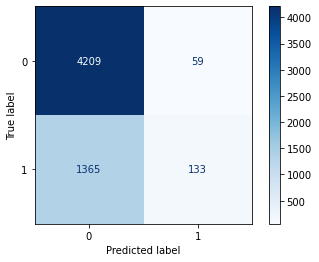

In [ ]:
# creating a confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, random_forest_test_predictions, cmap='Blues');

In [ ]:
# creating a record of the model run
model_data = {'model': model, 'time': time.ctime(), 'Train_r^2': train_r2,
              'Train_recall': train_recall, 'Train_precision': train_precision, 
              'Test_r^2': test_r2, 'Test_recall': test_recall, 'Test_precision':
               test_precision, 'Features_list': model_features}

record_model_data(model_data, file_name)

####KNN

In [ ]:
# Instantiating the knn model
knn = KNeighborsClassifier()
# creating a pipe and adding a scaler
knn_pipe = make_pipeline(preprocessor, knn)
# fitting the pipeline on the training data
knn_pipe.fit(X_train, y_train)
# predictions with knn model
knn_test_predictions = knn_pipe.predict(X_test)
knn_train_predictions = knn_pipe.predict(X_train)

In [ ]:
# training and test metrics
train_r2 = knn_pipe.score(X_train, y_train)
train_recall = recall_score(y_train, knn_train_predictions)
train_precision = precision_score(y_train, knn_train_predictions)

test_r2 = knn_pipe.score(X_test, y_test)
test_recall = recall_score(y_test, knn_test_predictions)
test_precision = precision_score(y_test, knn_test_predictions)

model_features = list(X_train.columns)
model = 'KNN'

In [ ]:
# printing metrics for train and test
print('-'*18 + 'KNN Metrics' + '-'*18 + '\n\n')
print('*'*10 + 'Train Metrics' + '*'*10)
print(f'Train R^2 {train_r2}')
print(f'Train Recall Score {train_recall}')
print(f'Train Precision Score {train_precision}')
print('\n\n'+'*'*10 + 'Test Metrics' + '*'*10)
print(f'Test R^2 {test_r2}')
print(f'Test Recall Score {test_recall}')
print(f'Test Precision Score {test_precision}')

------------------KNN Metrics------------------


**********Train Metrics**********
Train R^2 0.7995722048791768
Train Recall Score 0.39339875111507583
Train Precision Score 0.7025089605734767


**********Test Metrics**********
Test R^2 0.7147069025320847
Test Recall Score 0.21895861148197596
Test Precision Score 0.40846824408468246


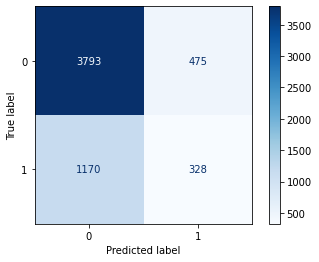

In [ ]:
# reviewing the confusion matrix for the best KNN model on the test data
ConfusionMatrixDisplay.from_predictions(y_test, knn_test_predictions, cmap='Blues');

In [ ]:
# creating a record of the model run
model_data = {'model': model, 'time': time.ctime(), 'Train_r^2': train_r2,
              'Train_recall': train_recall, 'Train_precision': train_precision, 
              'Test_r^2': test_r2, 'Test_recall': test_recall, 'Test_precision':
               test_precision, 'Features_list': model_features}

record_model_data(model_data, file_name)

####Neural Network

In [ ]:
# prepare dataset
preprocessor.fit(X_train)
X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# storing the dimension of X train
X_train_shape = X_train_processed.shape[1]
X_train_shape

23913

In [ ]:
# Function to help plot history of deep learning models

#def plot_history(history):
#  """Takes a keras model learning history and plots each metric"""
  
#  metrics = history.history.keys()
  
#  for metric in metrics:
#      if not 'val' in metric:
#        plt.plot(history.history[f'{metric}'], label=f'{metric}')
#        if f'val_{metric}' in metrics:
#          plt.plot(history.history[f'val_{metric}'], label=f'val_{metric}')
#        plt.legend()
#        plt.title(f'{metric}')
#        plt.show()

In [ ]:
def plot_history(history, metric=None):
  """plot loss and passed metric.  metric is passed as string and must match 'metric'
  argument in the compile step"""
  fig, axes = plt.subplots(2,1, figsize = (5,10))
  axes[0].plot(history.history['loss'], label = "train")
  axes[0].plot(history.history['val_loss'], label='test')
  axes[0].set_title('Loss')
  axes[0].legend()
  if metric:
    axes[1].plot(history.history[metric], label = 'train')
    axes[1].plot(history.history['val_' + metric], label = 'test')
    axes[1].set_title(metric)
    axes[1].legend()

  plt.show()

In [ ]:
# instantiate the base sequential model
base_model = Sequential()
# creating the first layer of the model
base_model.add(Dense(150, input_dim = X_train_shape, activation = 'relu'))
# adding addtional layers
base_model.add(Dense(150, activation = 'relu'))
# because this is a binary classification problem the last step will have one node and be a sigmoid activiation function
base_model.add(Dense(1, activation='sigmoid'))

In [ ]:
# compile the model
base_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# add different metrics to track/view

In [ ]:
# fittting the model
history = base_model.fit(X_train_processed, y_train,
                        validation_data = (X_test_processed, y_test),
                        epochs = 50, verbose = 0)

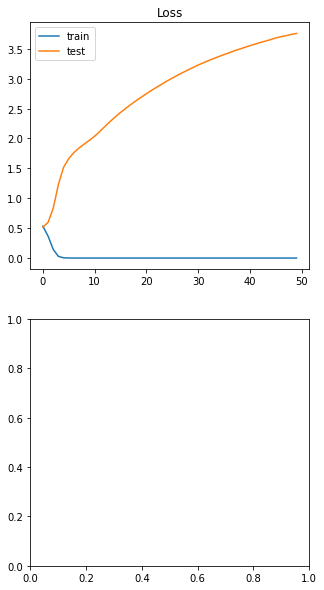

In [ ]:
# plotting the history using the function above
plot_history(history)

In [ ]:
# creating training and testing predictions. making sure to round them
nn_train_predictions = np.rint(base_model.predict(X_train_processed))
nn_test_predictions = np.rint(base_model.predict(X_test_processed))

# training classification report
print('Training Classification Report and Confusion Matrix')
print(classification_report(y_train, nn_train_predictions))
print(f'Neural Network Accuracy {accuracy_score(y_train, nn_train_predictions)}')

# creating the confusion matrix
ConfusionMatrixDisplay.from_predictions(y_train, nn_train_predictions, cmap='Greens');

NameError: ignored

In [ ]:
# testing classification report
print('Testing Classification Report and Confusion Matrix')
print(classification_report(y_test, nn_test_predictions))
print(f'Neural Network Accuracy {accuracy_score(y_test, nn_test_predictions)}')

# confusion matrix for the testing set
ConfusionMatrixDisplay.from_predictions(y_test, nn_test_predictions, cmap='Greens');